In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

!sudo apt-get install -y xvfb ffmpeg
!pip install 'xvfbwrapper==0.2.9'
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install tf-agents
!pip install gast

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
from datetime import datetime
import tensorflow as tf
import sklearn

import abc
import base64
import imageio
import io
import IPython
import numpy as np
import PIL.Image
import pyvirtualdisplay
import tensorflow_probability as tfp
import numpy as np
import shutil
import tempfile
import zipfile

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(13)

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Value and Policy based methods

Lets review the taxonomy of RL algorithms:


[[1](https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html)]

Our first categorisation for our choice of RL algorithm, is if the agent will use a **model** (either given or learns one) of the world (environment), often a function that predicts state transitions and rewards. Models allow us to **plan**  by simulating ahead what a would happen given a range of inputs. Agents can then distill results from planning into a learned policy (E.g. AlphaZero). When this works, it can result in a substantial improvement in sample efficiency (compared to non-model algorithms). However in practice a **model** is rarely known and instead has to learn a model only from experience, which leads to bias in the model can be exploited by the agent, resulting in an agent that performs well on the learned model, however poorly in the real environment. For this reason, training **model-based** learning is difficult.

**Model-free** agents, don't use a model, however tend to be more popular and easier to implement, they come in two broad categorisations **Value** (Q-Learning) and **Policy** based methods.

## Value based methods

Often denoted as *Q-learning*, we learn an approximator $Q_\theta(s,a)$ for the optimal action-value function, $Q^*(s,a)$. Often they use a objective function (Used as the cost to maximize to update the parameters on) based on the Bellman equation. This optomization is almost always performed **off-policy**, that allows each update to use data collected at any point during training, regardless of how the agent was choosing to explore the environment when the data was collected. The policy taken by the Q-learning agent is given by:

$$a(s) =  \operatorname{arg max}_{a} Q(s, a)$$

Q-Learning agents in TF-Agents are:
* [DQN](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) (Deep Q-Networks)
    * `from tf_agents.agents.dqn.dqn_agent import DqnAgent`
* [C51](https://arxiv.org/abs/1707.06887) (A DQN variation, that learns a distribution over return whose expectation is $Q^*$)
    * `from tf_agents.agents.categorical_dqn.categorical_dqn_agent import CategoricalDqnAgent`

## Policy based methods

Also known as *Policy Optomization*, where we parameterise the policy $\pi_\theta(a|s)$ and we keep updating its paramters until we converge to a performance that is no longer increasing. These optomise the parameterise $\theta$ either directly by gradient descent on the defined performance objective, often a **policy value** $\rho(\theta)$ (the expected reward we get when following $\pi_\theta$), or by maximising local approximations of $\rho(\theta)$. This often performed on **on-policy**, which restricts each update to only use data collected while acting according to the most recent version that policy $\pi$. Policy optomization often involves learning a value function approximator $V_\phi(s)$ for the on-policy value function $V^{\pi}(s)$, which gets used to update the policy.

Policy based agents in TF-Agents are:
* [REINFORCE](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf) (Vanilla Policy Optomization)
    * `from tf_agents.agents.reinforce.reinforce_agent import ReinforceAgent`
* [A2C / A3C](https://arxiv.org/abs/1602.01783) (Synchronous Actor Critic / Asynchronous Actor Critic) Gradient ascent to directly maximize performance. Combines REINFORCE with a learned baseline (Critic) to improve stability of learning. Can be trained parallelized (asynchronous) or synchronous for both discrete and continous action spaces.
    * `from tf_agents.agents.sac.sac_agent import SacAgent`, passing in a `critic_network_2` network keyword argument, as the second critic network to be used during optomization.
* [PPO](https://arxiv.org/abs/1707.06347) (Proximal Policy Optimization Algorithms: Actor-Critic) Maximizes a surrogate objective function which gives a conservative estimate for how much $\rho(\theta)$ will change as a result of the update. This actor critic scheme which uses bounded updates to the policy in order to make the learning process very stable.
    * `from tf_agents.agents.ppo.ppo_agent import PPOAgent`

## Trade-offs between Policy and Value based methods

The primary strength of policy optimization methods is that they are principled, in that we directly optimize for the thing we want (An optimal policy $\pi$). This tends to make them stable and reliable. In contrast, value based methods (Q-learning methods) only indirectly optimize for agent performance, by training $Q_{\theta}$ to satisfy a self-consistency equation (Bellman equation). There are many failure modes for this kind of learning, so it tends to be less stable. However Q-learning methods gain the advantage of being substantially more sample efficient when they do work, because they can reuse data more effectively than policy optimization techniques. Policy methods also perform best on continous action spaces.

## Interpolating between Policy and Value based methods

Policy optimization and Q-learning methods are not incompatible (and under some circumstances, it turns out, equivalent), and there exist a range of algorithms that live in between the two extremes. Algorithms that live on this spectrum are able to carefully trade-off between the strengths and weaknesses of either side.

TF-Agents includes:
* [DDPG](https://arxiv.org/abs/1509.02971) (Deep Deterministic Policy Gradient) An actor critic scheme for continuous action spaces which assumes that the policy is deterministic, and therefore it is able to use a replay buffer in order to improve sample efficiency.
    * `from tf_agents.agents.ddpg.ddpg_agent import DdpgAgent`
* [TD3](https://arxiv.org/pdf/1802.09477.pdf) Very similar to DDPG, i.e. an actor-critic for continuous action spaces, that uses a replay buffer in order to improve sample efficiency. TD3 uses two critic networks in order to mitigate the overestimation in the Q state-action value prediction, slows down the actor updates in order to increase stability and adds noise to actions while training the critic in order to smooth out the critic's predictions.
    * `from tf_agents.agents.td3.td3_agent import Td3Agent`
* [SAC](https://arxiv.org/abs/1801.01290) (Soft Actor-Critic) DDPG variant which uses stochastic policies, entropy regularization, and a few other tricks to stabilize learning and score higher than DDPG on standard benchmarks. Here optimizing a stochastic policy in an off-policy way. One of the key features of SAC is that it solves a maximum entropy reinforcement learning problem.
    * `from tf_agents.agents.sac.sac_agent import SacAgent`
    
## Advantage functions

Sometimes we don’t need to describe how good an action is in an absolute sense (Value function),however only how much better it is than others on average. Hence we want to know the relative advantage of that action. We make this concept precise with the advantage function.

The advantage function $A^{\pi}(s,a)$ corresponding to a policy $\pi$ describes how much better it is to take a specific action $a$ in state $s$, over randomly selecting an action according to $\pi(\cdot|s)$, assuming the agent acts according to $\pi$ forever after:

$$ A^{\pi}(s,a) = Q^{\pi}(s,a) - V^{\pi}(s)$$

# TF-Agents example

Lets compare and train some of these agents on the [inverted pendulum swingup](https://gym.openai.com/envs/Pendulum-v0/) problem. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright.

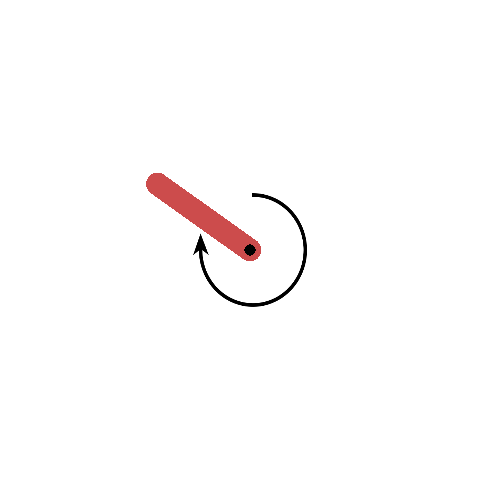

In [2]:
from tf_agents.environments import suite_gym
env_name = "Pendulum-v0"
env = suite_gym.load(env_name)
env.reset()
# Lets see a possible starting state
PIL.Image.fromarray(env.render())

## Problem Setup

In [3]:
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.agents.ddpg import critic_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.drivers import dynamic_step_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.networks import normal_projection_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import random_tf_policy

tf.compat.v1.enable_v2_behavior()


# Hyperparameters
factor = 1
ddpg_num_iterations = int(factor * 100000)  # @param {type:"integer"}
policy_num_iterations = 300  # @param {type:"integer"}

ddpg_initial_collect_steps = int(factor * 10000)  # @param {type:"integer"}
collect_steps_per_iteration = 1  # @param {type:"integer"}
collect_episodes_per_iteration = 2  # @param {type:"integer"}
ddpg_replay_buffer_capacity = int(factor * 1000000)  # @param {type:"integer"}
policy_replay_buffer_capacity = 2000  # @param {type:"integer"}

batch_size = 256  # @param {type:"integer"}

critic_learning_rate = 3e-4  # @param {type:"number"}
actor_learning_rate = 3e-4  # @param {type:"number"}
alpha_learning_rate = 3e-4  # @param {type:"number"}
target_update_tau = 0.005  # @param {type:"number"}
policy_learning_rate = 1e-3  # @param {type:"number"}
target_update_period = 1  # @param {type:"number"}
gamma = 0.99  # @param {type:"number"}
reward_scale_factor = 1.0  # @param {type:"number"}
gradient_clipping = None  # @param

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

ddpg_log_interval = int(factor * 5000)  # @param {type:"integer"}
policy_log_interval = 25  # @param {type:"integer"}

num_eval_episodes = 3  # @param {type:"integer"}
ddpg_eval_interval = int(factor * 100000)  # @param {type:"integer"}
policy_eval_interval = 50  # @param {type:"integer"}

# Create the training and evaluation environments
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Metrics


def compute_avg_return(environment, policy, num_episodes=1):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


# Embed video


def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)


def train_and_evaluate_agent_policy(tf_agent, name='agent'):
    tf_agent.initialize()

    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=tf_agent.collect_data_spec,
        batch_size=train_env.batch_size,
        max_length=policy_replay_buffer_capacity)

    tf_agent.train = common.function(tf_agent.train)

    # Train
    tf_agent.train_step_counter.assign(0)

    # Evaluate the agent's policy once before training.
    avg_return = compute_avg_return(
        eval_env, tf_agent.policy, num_eval_episodes)
    returns = [(0, avg_return)]

    for iteration in range(policy_num_iterations):
        # Collect a few episodes and save to the replay buffer.
        dynamic_episode_driver.DynamicEpisodeDriver(train_env,
                                                    tf_agent.collect_policy,
                                                    observers=[
                                                        replay_buffer.add_batch],
                                                    num_episodes=collect_episodes_per_iteration).run()

        # Use data from the buffer and update the agent's network.
        experience = replay_buffer.gather_all()
        train_loss = tf_agent.train(experience)
        replay_buffer.clear()

        step = tf_agent.train_step_counter.numpy()

        if step % policy_log_interval == 0:
            print('[{0}] step = {1}: loss = {2}'.format(
                iteration, step, train_loss.loss))

        if step % policy_eval_interval == 0:
            avg_return = compute_avg_return(
                eval_env, tf_agent.policy, num_eval_episodes)
            print('[{0}] step = {1}: Average Return = {2}'.format(
                iteration, step, avg_return))
            returns.append((step, avg_return))

        if step >= policy_num_iterations:
            break

    steps_list = [r[0] for r in returns]
    rewards_list = [r[1] for r in returns]
    plt.plot(steps_list, rewards_list)
    plt.ylabel('Average Return')
    plt.xlabel('Step')
    plt.title(name)
    plt.show()

    # Visualize policies for a few episodes
    num_episodes = 3
    video_filename = '{}.mp4'.format(name)
    with imageio.get_writer(video_filename, fps=60) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = tf_agent.policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())

    return returns, video_filename


def train_and_evaluate_agent_ddpg(tf_agent, name='agent'):
    tf_agent.initialize()

    eval_policy = greedy_policy.GreedyPolicy(tf_agent.policy)
    collect_policy = tf_agent.collect_policy

    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=tf_agent.collect_data_spec,
        batch_size=train_env.batch_size,
        max_length=ddpg_replay_buffer_capacity)

    initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
        train_env,
        collect_policy,
        observers=[replay_buffer.add_batch],
        num_steps=ddpg_initial_collect_steps)
    initial_collect_driver.run()

    # In order to save space, we only store the current observation in each row of the replay buffer.
    # But since the SAC Agent needs both the current and next observation to compute the loss, we always
    # sample two adjacent rows for each item in the batch by setting num_steps=2.
    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)

    iterator = iter(dataset)

    collect_driver = dynamic_step_driver.DynamicStepDriver(
        train_env,
        collect_policy,
        observers=[replay_buffer.add_batch],
        num_steps=collect_steps_per_iteration)

    # (Optional) Optimize by wrapping some of the code in a graph using TF function.
    tf_agent.train = common.function(tf_agent.train)
    collect_driver.run = common.function(collect_driver.run)

    # Reset the train step
    tf_agent.train_step_counter.assign(0)

    # Evaluate the agent's policy once before training.
    avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
    returns = [(0, avg_return)]

    for _ in range(ddpg_num_iterations):

        # Collect a few steps using collect_policy and save to the replay buffer.
        for _ in range(collect_steps_per_iteration):
            collect_driver.run()

        # Sample a batch of data from the buffer and update the agent's network.
        experience, unused_info = next(iterator)
        train_loss = tf_agent.train(experience)

        step = tf_agent.train_step_counter.numpy()

        if step % ddpg_log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss.loss))

        if step % ddpg_eval_interval == 0:
            avg_return = compute_avg_return(
                eval_env, eval_policy, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_return))
            returns.append((step, avg_return))

    steps_list = [r[0] for r in returns]
    rewards_list = [r[1] for r in returns]
    plt.plot(steps_list, rewards_list)
    plt.ylabel('Average Return')
    plt.xlabel('Step')
    plt.title(name)
    plt.show()

    # Visualize policies for a few episodes
    num_episodes = 3
    video_filename = '{}.mp4'.format(name)
    with imageio.get_writer(video_filename, fps=60) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = tf_agent.policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())

    return returns, video_filename

# Agents

## Vanilla Policy Gradient (REINFORCE)

[Vanilla Policy Optomization](https://www.tensorflow.org/agents/api_docs/python/tf_agents/agents/ReinforceAgent), we expect other methods to outperform this, this will need an `Actor Network` that can learn to predict the action given an observation from the environment. [[2](https://spinningup.openai.com/en/latest/algorithms/vpg.html)]

We can easily create an `Actor Network` using the specs of the observations and actions. We can specify the layers in the network which, in this example, is the `actor_fc_layer_params` argument set to a tuple of `ints` representing the sizes of each hidden layer (see the Hyperparameters section above).


REINFORCE is an on-policy algorithm. It can be used for environments with either discrete or continuous action spaces.

### Equations

Let $\pi_{\theta}$ denote a policy with parameters $\theta$, and $\rho(\pi_{\theta})$ denote the expected finite-horizon undiscounted return of the policy. The gradient of $\rho(\pi_{\theta})$ is

$$\nabla_{\theta} \rho(\pi_{\theta}) = E_{\tau \sim \pi_{\theta}}{
    \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) A^{\pi_{\theta}}(s_t,a_t)
    }$$

where $\tau$ is a trajectory and $A^{\pi_{\theta}}$ is the advantage function for the current policy.

The policy gradient algorithm works by updating policy parameters via stochastic gradient ascent on policy performance:

$$ \theta_{k+1} = \theta_k + \alpha \nabla_{\theta} J(\pi_{\theta_k}) $$

Policy gradient implementations typically compute advantage function estimates based on the infinite-horizon discounted return, despite otherwise using the finite-horizon undiscounted policy gradient formula.

### Exploration vs. Exploitation

REINFORCE trains a stochastic policy in an on-policy way. This means that it explores by sampling actions according to the latest version of its stochastic policy. The amount of randomness in action selection depends on both initial conditions and the training procedure. Over the course of training, the policy typically becomes progressively less random, as the update rule encourages it to exploit rewards that it has already found. This may cause the policy to get trapped in local optima.

[24] step = 25: loss = 8.06582260131836
[49] step = 50: loss = -0.9648714065551758
[49] step = 50: Average Return = -1351.0272216796875
[74] step = 75: loss = -0.4046287536621094
[99] step = 100: loss = -15.156167030334473
[99] step = 100: Average Return = -1454.9041748046875
[124] step = 125: loss = 2.7527332305908203
[149] step = 150: loss = -0.7026224136352539
[149] step = 150: Average Return = -1389.4117431640625
[174] step = 175: loss = -8.852677345275879
[199] step = 200: loss = -2.7687854766845703
[199] step = 200: Average Return = -1272.0289306640625
[224] step = 225: loss = -1.7971830368041992
[249] step = 250: loss = 1.3031983375549316
[249] step = 250: Average Return = -1041.46435546875
[274] step = 275: loss = -0.8766865730285645
[299] step = 300: loss = -7.38838005065918
[299] step = 300: Average Return = -1407.9981689453125


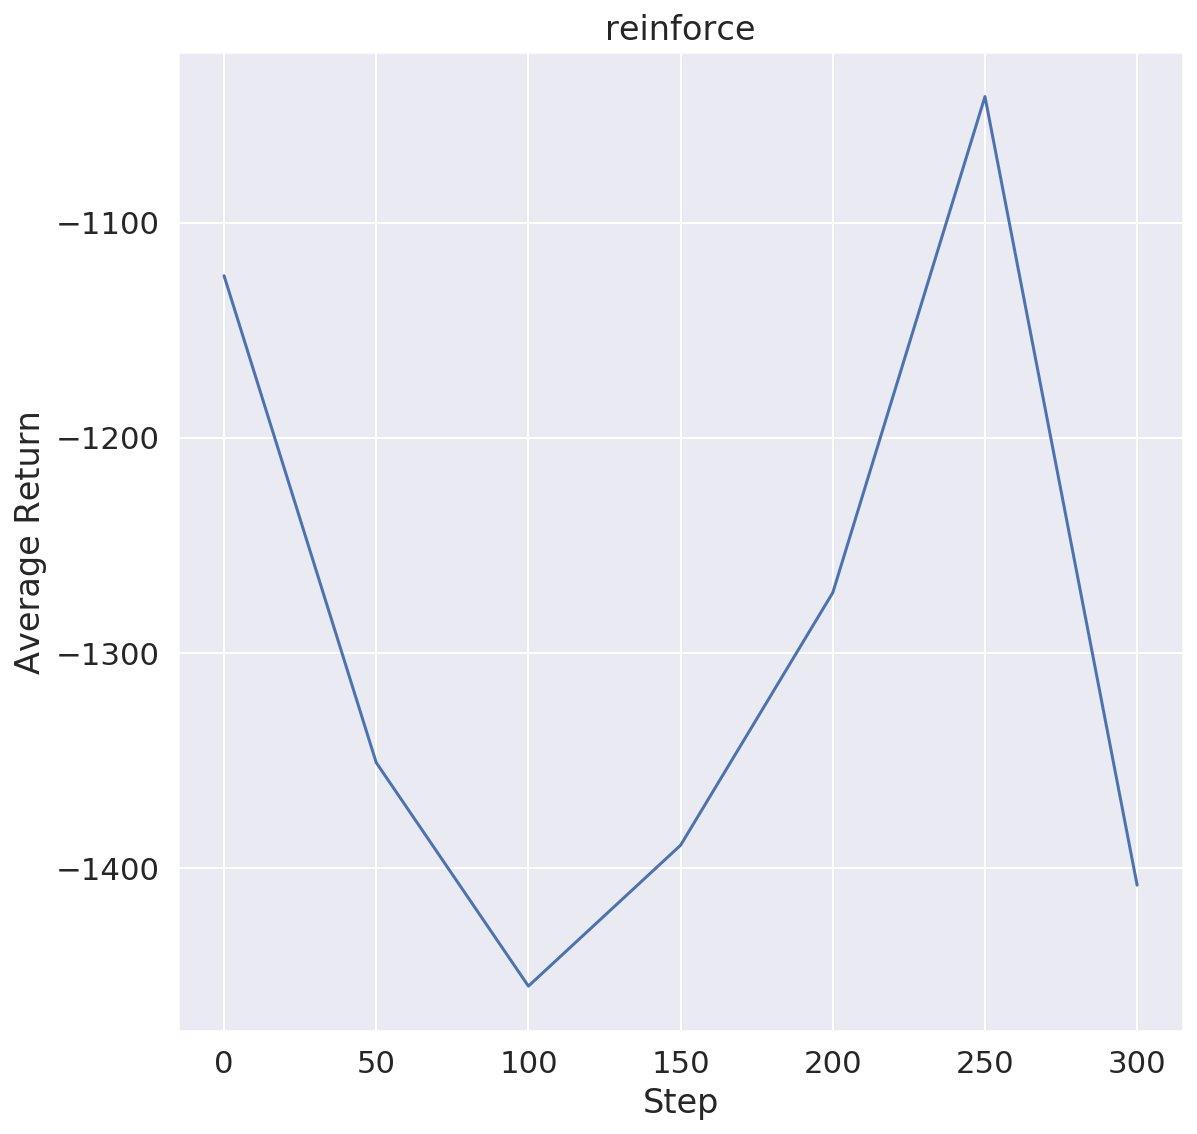

In [4]:
from tf_agents.agents.reinforce import reinforce_agent

actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=actor_fc_layer_params)

global_step = tf.compat.v2.Variable(0)
tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=actor_learning_rate),
    train_step_counter=global_step)

returns, video_filename = train_and_evaluate_agent_policy(tf_agent, name='reinforce')
embed_mp4(video_filename)

## Proximal Policy Optimization (PPO)

Proximal Policy Optimization: Actor-Critic. Maximizes a surrogate objective function which gives a conservative esimate for how much $\rho(\theta)$ will change as a result of the update. This actor critic scheme which uses bounded updates to the policy in order to make the learning process very stable. [[3](https://spinningup.openai.com/en/latest/algorithms/ppo.html)]


This variation is also known as *PPO-Clip*, it is an on-policy algorithm. It can be used for environments with either discrete or continuous action spaces.

### Equations

PPO-clip updates policies via

$$ \theta_{k+1} = \arg \max_{\theta} \underset{s,a \sim \pi_{\theta_k}}{{\mathrm E}}\left[
    L(s,a,\theta_k, \theta)\right] $$

typically taking multiple steps of (usually minibatch) SGD to maximize the objective. Here $L$ is given by

$$ L(s,a,\theta_k,\theta) = \min\left(
\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}  A^{\pi_{\theta_k}}(s,a), \;\;
\text{clip}\left(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}, 1 - \epsilon, 1+\epsilon \right) A^{\pi_{\theta_k}}(s,a)
\right) $$

in which $\epsilon$ is a (small) hyperparameter which roughly says how far away the new policy is allowed to go from the old.

This is a pretty complex expression, and it’s hard to tell at first glance what it’s doing, or how it helps keep the new policy close to the old policy. As it turns out, there’s a considerably simplified version of this objective which is a bit easier to grapple with (and is also the version we implement in our code):

$$ L(s,a,\theta_k,\theta) = \min\left(
\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}  A^{\pi_{\theta_k}}(s,a), \;\;
g(\epsilon, A^{\pi_{\theta_k}}(s,a))
\right) $$

where

$$ g(\epsilon, A) = 
    \begin{cases}
    (1 + \epsilon) A & A \geq 0 \\
    (1 - \epsilon) A & A < 0
    \end{cases}
$$

To figure out what intuition to take away from this, let’s look at a single state-action pair $(s,a)$, and think of cases.

**Advantage is positive**: Suppose the advantage for that state-action pair is positive, in which case its contribution to the objective reduces to

$$ L(s,a,\theta_k,\theta) = \min\left(
\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}, (1 + \epsilon)
\right)  A^{\pi_{\theta_k}}(s,a) $$

Because the advantage is positive, the objective will increase if the action becomes more likely—that is, if $\pi_{\theta}(a|s)$ increases. But the min in this term puts a limit to how much the objective can increase. Once $\pi_{\theta}(a|s) > (1+\epsilon) \pi_{\theta_k}(a|s)$, the min kicks in and this term hits a ceiling of $(1+\epsilon) A^{\pi_{\theta_k}}(s,a)$. Thus: the new policy does not benefit by going far away from the old policy.

**Advantage is negative**: Suppose the advantage for that state-action pair is negative, in which case its contribution to the objective reduces to

$$ L(s,a,\theta_k,\theta) = \max\left(
\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}, (1 - \epsilon)
\right)  A^{\pi_{\theta_k}}(s,a) $$

Because the advantage is negative, the objective will increase if the action becomes less likely—that is, if $\pi_{\theta}(a|s)$ decreases. But the max in this term puts a limit to how much the objective can increase. Once $\pi_{\theta}(a|s) < (1-\epsilon) \pi_{\theta_k}(a|s)$, the max kicks in and this term hits a ceiling of $(1-\epsilon) A^{\pi_{\theta_k}}(s,a)$. Thus, again: the new policy does not benefit by going far away from the old policy.

What we have seen so far is that clipping serves as a regularizer by removing incentives for the policy to change dramatically, and the hyperparameter $\epsilon$ corresponds to how far away the new policy can go from the old while still profiting the objective.

### Exploration vs. Exploitation

PPO trains a stochastic policy in an on-policy way. This means that it explores by sampling actions according to the latest version of its stochastic policy. The amount of randomness in action selection depends on both initial conditions and the training procedure. Over the course of training, the policy typically becomes progressively less random, as the update rule encourages it to exploit rewards that it has already found. This may cause the policy to get trapped in local optima.

[0] step = 25: loss = 159199.0
[1] step = 50: loss = 191677.109375
[1] step = 50: Average Return = -1167.8448486328125
[2] step = 75: loss = 162661.203125
[3] step = 100: loss = 191578.75
[3] step = 100: Average Return = -938.8040161132812
[4] step = 125: loss = 191461.234375
[5] step = 150: loss = 171037.171875
[5] step = 150: Average Return = -1580.6292724609375
[6] step = 175: loss = 190906.90625
[7] step = 200: loss = 190586.25
[7] step = 200: Average Return = -1393.9642333984375
[8] step = 225: loss = 156244.53125
[9] step = 250: loss = 189134.546875
[9] step = 250: Average Return = -1064.8873291015625
[10] step = 275: loss = 187796.671875
[11] step = 300: loss = 165212.4375
[11] step = 300: Average Return = -1258.4388427734375


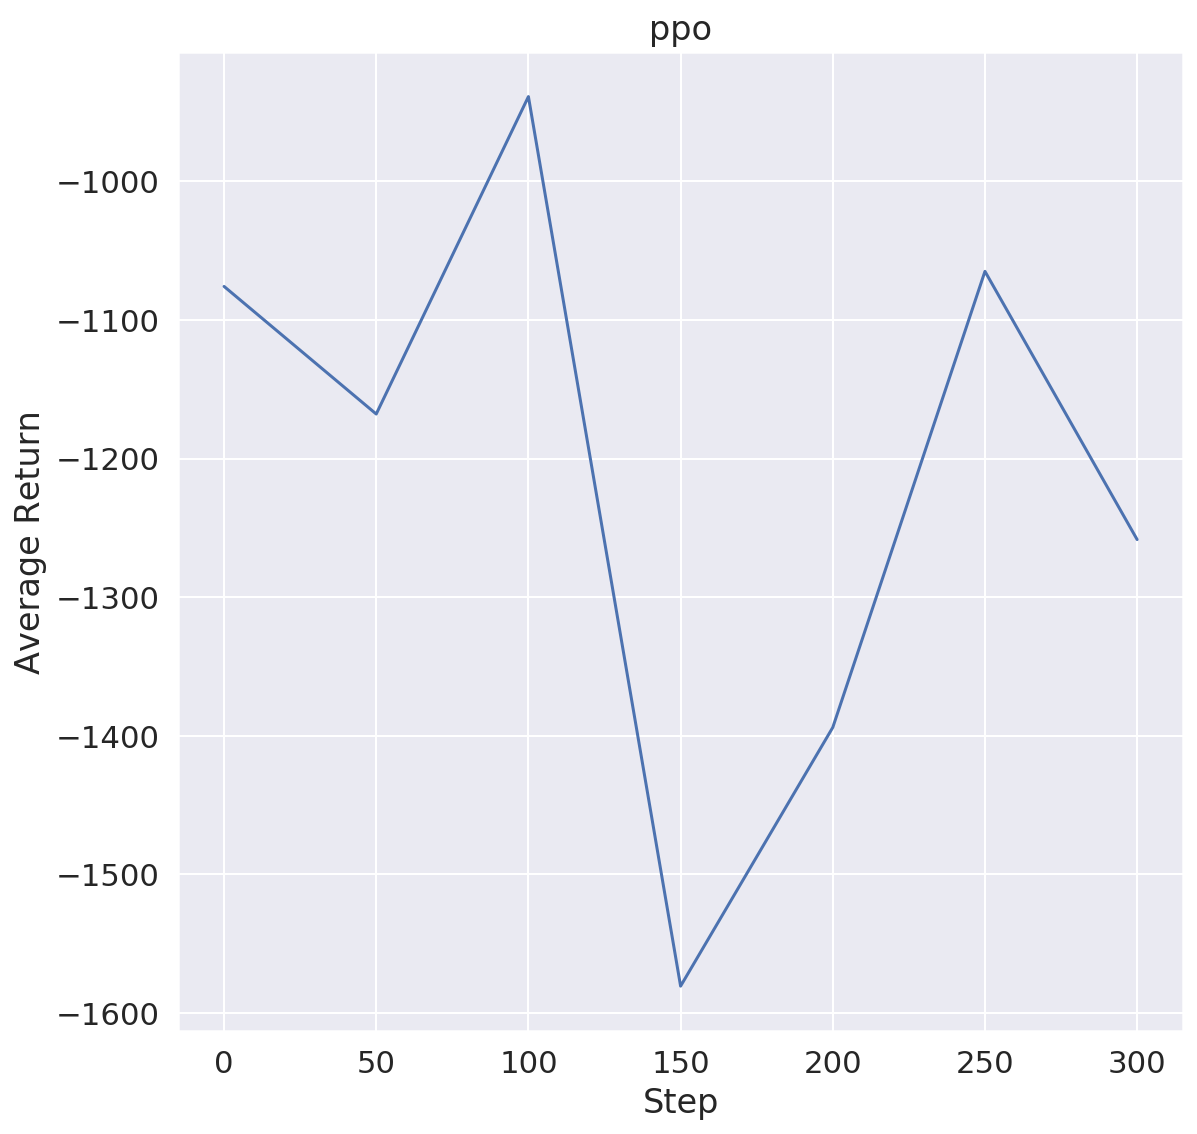

In [5]:
from tf_agents.agents.ppo import ppo_agent

from tf_agents.networks.value_network import ValueNetwork

actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=actor_fc_layer_params)

value_net = ValueNetwork(
    train_env.observation_spec()
)

global_step = tf.compat.v2.Variable(0)
tf_agent = ppo_agent.PPOAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_net=actor_net,
    value_net=value_net,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=actor_learning_rate),
    train_step_counter=global_step)

returns, video_filename = train_and_evaluate_agent_policy(tf_agent, name='ppo')
embed_mp4(video_filename)

## Deep Deterministic Policy Gradient (Ddpg)

(Deep Deterministic Policy Gradient) An actor critic scheme for continuous action spaces which assumes that the policy is deterministic, and therefore it is able to use a replay buffer in order to improve sample efficiency. [[4](https://spinningup.openai.com/en/latest/algorithms/ddpg.html)]

TF-Agents implements the Deep Deterministic Policy Gradient (DDPG) algorithm from ["Continuous control with deep reinforcement learning"](https://arxiv.org/abs/1509.02971) 2019.

Deep Deterministic Policy Gradient (DDPG) is an algorithm which concurrently learns a Q-function and a policy. It uses off-policy data and the Bellman equation to learn the Q-function, and uses the Q-function to learn the policy.

This approach is closely connected to Q-learning, and is motivated the same way: if we know the optimal action-value function $Q^*(s,a)$, then in any given state, the optimal action $a^*(s)$ can be found by solving

$$a^*(s) = \arg \max_a Q^*(s,a)$$

DDPG interleaves learning an approximator to $Q^*(s,a)$ with learning an approximator to $a^*(s)$, and it does so in a way which is specifically adapted for environments with continuous action spaces.

When there are a finite number of discrete actions, the max poses no problem, because we can just compute the Q-values for each action separately and directly compare them. (This also immediately gives us the action which maximizes the Q-value.) But when the action space is continuous, we can’t exhaustively evaluate the space, and solving the optimization problem is highly non-trivial. Using a normal optimization algorithm would make calculating $\max_a Q^*(s,a)$ a painfully expensive subroutine. And since it would need to be run every time the agent wants to take an action in the environment, this is unacceptable.

Because the action space is continuous, the function $Q^*(s,a)$ is presumed to be differentiable with respect to the action argument. This allows us to set up an efficient, gradient-based learning rule for a policy $\mu(s)$ which exploits that fact. Then, instead of running an expensive optimization subroutine each time we wish to compute $\max_a Q(s,a)$, we can approximate it with $\max_a Q(s,a) \approx Q(s,\mu(s))$.

DDPG is an off-policy algorithm. It can only be used for environments with continuous action spaces, and can be thought of as being deep Q-learning for continuous action spaces.

### Equations

Here, we’ll explain the math behind the two parts of DDPG: learning a Q function, and learning a policy.

#### The Q-Learning Side of DDPG

First, let’s recap the Bellman equation describing the optimal action-value function, $Q^*(s,a)$. It’s given by

$$ Q^*(s,a) = \underset{s' \sim P}{{\mathrm E}}\left[r(s,a) + \gamma \max_{a'} Q^*(s', a')\right] $$

where $s' \sim P$ is shorthand for saying that the next state, $s'$, is sampled by the environment from a distribution $P(\cdot| s,a)$.

This Bellman equation is the starting point for learning an approximator to $Q^*(s,a)$. Suppose the approximator is a neural network $Q_{\phi}(s,a)$, with parameters $\phi$, and that we have collected a set ${\mathcal D}$ of transitions $(s,a,r,s',d)$ (where $d$ indicates whether state $s'$ is terminal). We can set up a **mean-squared Bellman error (MSBE)** function, which tells us roughly how closely $Q_{\phi}$ comes to satisfying the Bellman equation:

$$ L(\phi, {\mathcal D}) = \underset{(s,a,r,s',d) \sim {\mathcal D}}{{\mathrm E}}\left[
    \Bigg( Q_{\phi}(s,a) - \left(r + \gamma (1 - d) \max_{a'} Q_{\phi}(s',a') \right) \Bigg)^2
    \right] $$

Here, in evaluating $(1-d)$, we’ve used a Python convention of evaluating `True` to 1 and `False` to zero. Thus, when `d==True`—which is to say, when $s'$ is a terminal state—the Q-function should show that the agent gets no additional rewards after the current state.

Q-learning algorithms for function approximators, such as DQN (and all its variants) and DDPG, are largely based on minimizing this MSBE loss function. There are two main tricks employed by all of them which are worth describing, and then a specific detail for DDPG.

**Trick One: Replay Buffers**. All standard algorithms for training a deep neural network to approximate $Q^*(s,a)$ make use of an experience replay buffer. This is the set ${\mathcal D}$ of previous experiences. In order for the algorithm to have stable behaviour, the replay buffer should be large enough to contain a wide range of experiences, but it may not always be good to keep everything. If we only use the very-most recent data, we will overfit to that and things will break; if we use too much experience, we may slow down our learning. This may take some tuning to get right.

**Trick Two: Target Networks**. Q-learning algorithms make use of **target networks**. The term

$$ r + \gamma (1 - d) \max_{a'} Q_{\phi}(s',a') $$

is called the **target**, because when we minimize the MSBE loss, we are trying to make the Q-function be more like this target. Problematically, the target depends on the same parameters we are trying to train: $\phi$. This makes MSBE minimization unstable. The solution is to use a set of parameters which comes close to $\phi$, but with a time delay—that is to say, a second network, called the target network, which lags the first. The parameters of the target network are denoted $\phi_{\text{targ}}$.

In DQN-based algorithms, the target network is just copied over from the main network every some-fixed-number of steps. In DDPG-style algorithms, the target network is updated once per main network update by polyak averaging:

$$ \phi_{\text{targ}} \leftarrow \rho \phi_{\text{targ}} + (1 - \rho) \phi $$

where $\rho$ is a hyperparameter between 0 and 1 (usually close to 1).

**DDPG Detail: Calculating the Max Over Actions in the Target**. As mentioned earlier: computing the maximum over actions in the target is a challenge in continuous action spaces. DDPG deals with this by using a **target policy network** to compute an action which approximately maximizes $Q_{\phi_{\text{targ}}}$. The target policy network is found the same way as the target Q-function: by polyak averaging the policy parameters over the course of training.

Putting it all together, Q-learning in DDPG is performed by minimizing the following MSBE loss with stochastic gradient descent:

$$ L(\phi, {\mathcal D}) = \underset{(s,a,r,s',d) \sim {\mathcal D}}{{\mathrm E}}\left[
    \Bigg( Q_{\phi}(s,a) - \left(r + \gamma (1 - d) Q_{\phi_{\text{targ}}}(s', \mu_{\theta_{\text{targ}}}(s')) \right) \Bigg)^2
    \right] $$

where $\mu_{\theta_{\text{targ}}}$ is the target policy.

#### The Policy Learning Side of DDPG

Policy learning in DDPG is fairly simple. We want to learn a deterministic policy $\mu_{\theta}(s)$ which gives the action that maximizes $Q_{\phi}(s,a)$. Because the action space is continuous, and we assume the Q-function is differentiable with respect to action, we can just perform gradient ascent (with respect to policy parameters only) to solve

$\max_{\theta} \underset{s \sim {\mathcal D}}{{\mathrm E}}\left[ Q_{\phi}(s, \mu_{\theta}(s)) \right]$

Note that the Q-function parameters are treated as constants here.

### Exploration vs. Exploitation

DDPG trains a deterministic policy in an off-policy way. Because the policy is deterministic, if the agent were to explore on-policy, in the beginning it would probably not try a wide enough variety of actions to find useful learning signals. To make DDPG policies explore better, we add noise to their actions at training time. The authors of the original DDPG paper recommended time-correlated OU noise, but more recent results suggest that uncorrelated, mean-zero Gaussian noise works perfectly well. Since the latter is simpler, it is preferred. To facilitate getting higher-quality training data, we may reduce the scale of the noise over the course of training. (We do not do this in our implementation, and keep noise scale fixed throughout.)

At test time, to see how well the policy exploits what it has learned, we do not add noise to the actions.

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


step = 5000: loss = 45.19623947143555
step = 10000: loss = 9.158523559570312
step = 15000: loss = 78.84381866455078
step = 20000: loss = 71.21947479248047
step = 25000: loss = 9.071224212646484
step = 30000: loss = 9.666265487670898
step = 35000: loss = 67.69287872314453
step = 40000: loss = 172.80889892578125
step = 45000: loss = 12.851096153259277
step = 50000: loss = 142.69183349609375
step = 55000: loss = 201.4624786376953
step = 60000: loss = 185.8665313720703
step = 65000: loss = 23.49108123779297
step = 70000: loss = 42.53995132446289
step = 75000: loss = 46.117225646972656
step = 80000: loss = 43.024932861328125
step = 85000: loss = 21.035581588745117
step = 90000: loss = 179.54420471191406
step = 95000: loss = 116.7349624633789
step = 100000: loss = 78.56392669677734
step = 100000: Average Return = -84.12203979492188


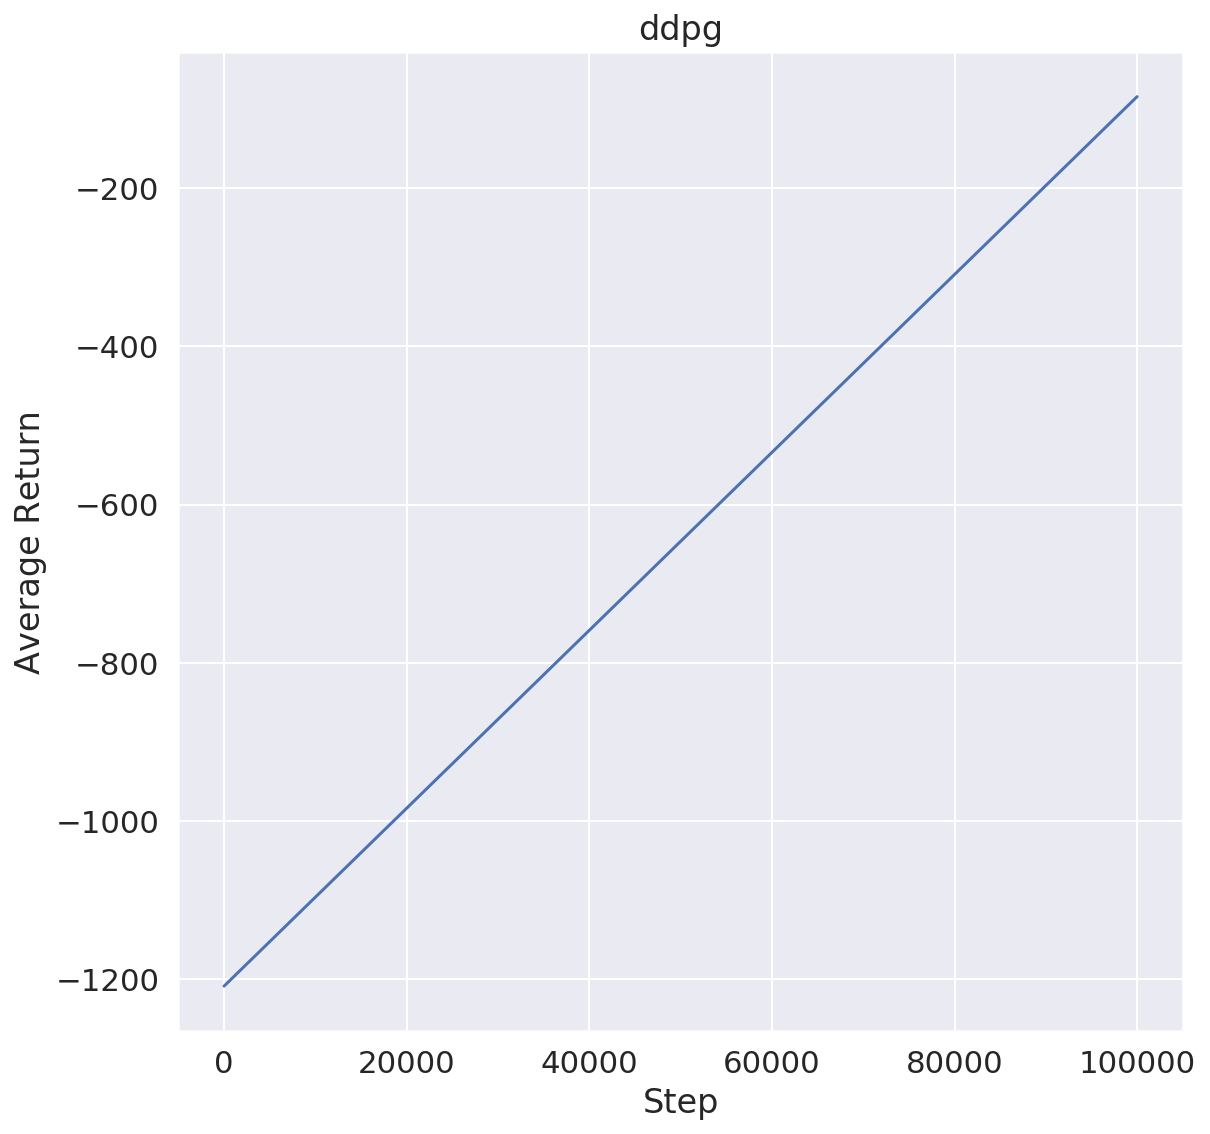

In [6]:
from tf_agents.agents.ddpg import ddpg_agent, actor_network, critic_network

actor_net = actor_network.ActorNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=actor_fc_layer_params)

critic_net = critic_network.CriticNetwork(
    (train_env.observation_spec(),  train_env.action_spec()),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=critic_joint_fc_layer_params)

global_step = tf.compat.v2.Variable(0)
tf_agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    train_step_counter=global_step)

returns, video_filename = train_and_evaluate_agent_ddpg(tf_agent, name='ddpg')
embed_mp4(video_filename)

## Soft Actor-Critic (SAC)

(Soft Actor-Critic) DDPG variant which uses stochastic policies, entropy regularization, and a few other tricks to stabilize learning and score higher than DDPG on standard benchmarks. Here optimizing a stochastic policy in an off-policy way. One of the key features of SAC is that it solves a maximum entropy reinforcement learning problem. [[5](https://spinningup.openai.com/en/latest/algorithms/sac.html)]

TF-Agents implements the Soft Actor-Critic (SAC) algorithm from ["Soft Actor-Critic Algorithms and Applications"](https://arxiv.org/abs/1812.05905) 2019.

Soft Actor Critic (SAC) is an algorithm that optimizes a stochastic policy in an off-policy way, forming a bridge between stochastic policy optimization and DDPG-style approaches. It isn’t a direct successor to TD3 (having been published roughly concurrently), but it incorporates the clipped double-Q trick, and due to the inherent stochasticity of the policy in SAC, it also winds up benefiting from something like target policy smoothing.

A central feature of SAC is **entropy regularization**. The policy is trained to maximize a trade-off between expected return and entropy, a measure of randomness in the policy. This has a close connection to the exploration-exploitation trade-off: increasing entropy results in more exploration, which can accelerate learning later on. It can also prevent the policy from prematurely converging to a bad local optimum.

SAC is an off-policy algorithm, often it is implemented to only support environments with continous action spaces, although an alternative version of SAC (which slightly changes the policy update rule) can be implemented to handle discrete action spaces.

### Equations

To explain Soft Actor Critic, we first have to introduce the entropy-regularized reinforcement learning setting. In entropy-regularized RL, there are slightly-different equations for value functions.

#### Entropy-Regularized Reinforcement Learning

Entropy is a quantity which, roughly speaking, says how random a random variable is. If a coin is weighted so that it almost always comes up heads, it has low entropy; if it’s evenly weighted and has a half chance of either outcome, it has high entropy.

Let $x$ be a random variable with probability mass or density function $P$. The entropy $H$ of $x$ is computed from its distribution $P$ according to

$$ H(P) = E_{x \sim P}{-\log P(x)} $$

In entropy-regularized reinforcement learning, the agent gets a bonus reward at each time step proportional to the entropy of the policy at that timestep. This changes the RL problem to:

$$ \pi^* = \arg \max_{\pi} E_{\tau \sim \pi}{ \sum_{t=0}^{\infty} \gamma^t \bigg( R(s_t, a_t, s_{t+1}) + \alpha H\left(\pi(\cdot|s_t)\right) \bigg)} $$

where $\alpha > 0$ is the trade-off coefficient. (Note: we’re assuming an infinite-horizon discounted setting here, and we’ll do the same for the rest of this page.) We can now define the slightly-different value functions in this setting. $V^{\pi}$ is changed to include the entropy bonuses from every timestep:

$$ V^{\pi}(s) = E_{\tau \sim \pi}{ \left. \sum_{t=0}^{\infty} \gamma^t \bigg( R(s_t, a_t, s_{t+1}) + \alpha H\left(\pi(\cdot|s_t)\right) \bigg) \right| s_0 = s} $$

$Q^{\pi}$ is changed to include the entropy bonuses from every timestep except the first:

$$ Q^{\pi}(s,a) = E_{\tau \sim \pi}{ \left. \sum_{t=0}^{\infty} \gamma^t  R(s_t, a_t, s_{t+1}) + \alpha \sum_{t=1}^{\infty} \gamma^t H\left(\pi(\cdot|s_t)\right)\right| s_0 = s, a_0 = a} $$

With these definitions, $V^{\pi}$ and $Q^{\pi}$ are connected by:

$$ V^{\pi}(s) = E_{a \sim \pi}{Q^{\pi}(s,a)} + \alpha H\left(\pi(\cdot|s)\right) $$

and the Bellman equation for $Q^{\pi}$ is

$$ Q^{\pi}(s,a) = E_{s' \sim P \\ a' \sim \pi}{R(s,a,s') + \gamma\left(Q^{\pi}(s',a') + \alpha H\left(\pi(\cdot|s')\right) \right)} $$
$$ = E_{s' \sim P}{R(s,a,s') + \gamma V^{\pi}(s')} $$

### Soft Actor-Critic

SAC concurrently learns a policy $\pi_{\theta}$ and two Q-functions $Q_{\phi_1}, Q_{\phi_2}$. There are two variants of SAC that are currently standard: one that uses a fixed entropy regularization coefficient $\alpha$, and another that enforces an entropy constraint by varying $\alpha$ over the course of training. For simplicity, we make use of the version with a fixed entropy regularization coefficient, but the entropy-constrained variant is generally preferred by practitioners.

### Learning Q

The Q-functions are learned in a similar way to TD3, as both Q-functions are learned with MSBE minimization, by regressing to a single shared target, the shared target is computed using target Q-networks, and the target Q-networks are obtained by polyak averaging the Q-network parameters over the course of training and the shared target makes use of the **clipped double-Q** trick. However there are also some differences such as the target also includes a term that comes from SAC’s use of entropy regularization, the next-state actions used in the target come from the current policy instead of a target policy and there is no explicit target policy smoothing. TD3 trains a deterministic policy, and so it accomplishes smoothing by adding random noise to the next-state actions. SAC trains a stochastic policy, and so the noise from that stochasticity is sufficient to get a similar effect.

Before we give the final form of the Q-loss, let’s take a moment to discuss how the contribution from entropy regularization comes in. We’ll start by taking our recursive Bellman equation for the entropy-regularized $Q^{\pi}$ from earlier, and rewriting it a little bit by using the definition of entropy:

$$ Q^{\pi}(s,a) = E_{s' \sim P \\ a' \sim \pi}{R(s,a,s') + \gamma\left(Q^{\pi}(s',a') + \alpha H\left(\pi(\cdot|s')\right) \right)} $$ 


$$ = E_{s' \sim P \\ a' \sim \pi}{R(s,a,s') + \gamma\left(Q^{\pi}(s',a') - \alpha \log \pi(a'|s') \right)} $$


The RHS is an expectation over next states (which come from the replay buffer) and next actions (which come from the current policy, and **not** the replay buffer). Since it’s an expectation, we can approximate it with samples:

$$ Q^{\pi}(s,a) \approx r + \gamma\left(Q^{\pi}(s',\tilde{a}') - \alpha \log \pi(\tilde{a}'|s') \right), \;\;\;\;\; \tilde{a}' \sim \pi(\cdot|s') $$

SAC sets up the MSBE loss for each Q-function using this kind of sample approximation for the target. The only thing still undetermined here is which Q-function gets used to compute the sample backup: like TD3, SAC uses the clipped double-Q trick, and takes the minimum Q-value between the two Q approximators.

Putting it all together, the loss functions for the Q-networks in SAC are:

$$ L(\phi_i, {\mathcal D}) = \underset{(s,a,r,s',d) \sim {\mathcal D}}{{\mathrm E}}\left[
    \Bigg( Q_{\phi_i}(s,a) - y(r,s',d) \Bigg)^2
    \right] $$
    
where the target is given by

$$ y(r, s', d) = r + \gamma (1 - d) \left( \min_{j=1,2} Q_{\phi_{\text{targ},j}}(s', \tilde{a}') - \alpha \log \pi_{\theta}(\tilde{a}'|s') \right), \;\;\;\;\; \tilde{a}' \sim \pi_{\theta}(\cdot|s')$$

**Learning the Policy**. The policy should, in each state, act to maximize the expected future return plus expected future entropy. That is, it should maximize $V^{\pi}(s)$, which we expand out into

$$ V^{\pi}(s) = E_{a \sim \pi}{Q^{\pi}(s,a)} + \alpha H\left(\pi(\cdot|s)\right) $$
$$ = E_{a \sim \pi} {Q^{\pi}(s,a) - \alpha \log \pi(a|s)} $$

The way we optimize the policy makes use of the **reparameterization trick**, in which a sample from $\pi_{\theta}(\cdot|s)$ is drawn by computing a deterministic function of state, policy parameters, and independent noise. To illustrate: following the authors of the SAC paper, we use a squashed Gaussian policy, which means that samples are obtained according to

$$ \tilde{a}_{\theta}(s, \xi) = \tanh\left( \mu_{\theta}(s) + \sigma_{\theta}(s) \odot \xi \right), \;\;\;\;\; \xi \sim \mathcal{N}(0, I) $$

The reparameterization trick allows us to rewrite the expectation over actions (which contains a pain point: the distribution depends on the policy parameters) into an expectation over noise (which removes the pain point: the distribution now has no dependence on parameters):

$$ E_{a \sim \pi_{\theta}}{Q^{\pi_{\theta}}(s,a) - \alpha \log \pi_{\theta}(a|s)} = E_{\xi \sim \mathcal{N}}{Q^{\pi_{\theta}}(s,\tilde{a}_{\theta}(s,\xi)) - \alpha \log \pi_{\theta}(\tilde{a}_{\theta}(s,\xi)|s)} $$

To get the policy loss, the final step is that we need to substitute $Q^{\pi_{\theta}}$ with one of our function approximators. Unlike in TD3, which uses $Q_{\phi_1}$ (just the first Q approximator), SAC uses $\min_{j=1,2} Q_{\phi_j}$ (the minimum of the two Q approximators). The policy is thus optimized according to

$$ \max_{\theta} E_{s \sim \mathcal{D} \\ \xi \sim \mathcal{N}}{\min_{j=1,2} Q_{\phi_j}(s,\tilde{a}_{\theta}(s,\xi)) - \alpha \log \pi_{\theta}(\tilde{a}_{\theta}(s,\xi)|s)} $$

which is almost the same as the DDPG and TD3 policy optimization, except for the min-double-Q trick, the stochasticity, and the entropy term.

### Exploration vs. Exploitation

SAC trains a stochastic policy with entropy regularization, and explores in an on-policy way. The entropy regularization coefficient $\alpha$ explicitly controls the explore-exploit tradeoff, with higher $\alpha$ corresponding to more exploration, and lower $\alpha$ corresponding to more exploitation. The right coefficient (the one which leads to the stablest / highest-reward learning) may vary from environment to environment, and could require careful tuning.

At test time, to see how well the policy exploits what it has learned, we remove stochasticity and use the mean action instead of a sample from the distribution. This tends to improve performance over the original stochastic policy.

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


step = 5000: loss = 99.80712127685547
step = 10000: loss = 204.59425354003906
step = 15000: loss = 111.9655990600586
step = 20000: loss = 270.3404235839844
step = 25000: loss = 339.5435485839844
step = 30000: loss = 189.65277099609375
step = 35000: loss = 458.0792236328125
step = 40000: loss = 115.81196594238281
step = 45000: loss = 126.300048828125
step = 50000: loss = 90.23560333251953
step = 55000: loss = 82.26104736328125
step = 60000: loss = 358.9587097167969
step = 65000: loss = 116.70611572265625
step = 70000: loss = 93.32209777832031
step = 75000: loss = 124.05563354492188
step = 80000: loss = 86.4576644897461
step = 85000: loss = 114.48477935791016
step = 90000: loss = 114.4925308227539
step = 95000: loss = 113.13996887207031
step = 100000: loss = 82.95805358886719
step = 100000: Average Return = -90.52265167236328


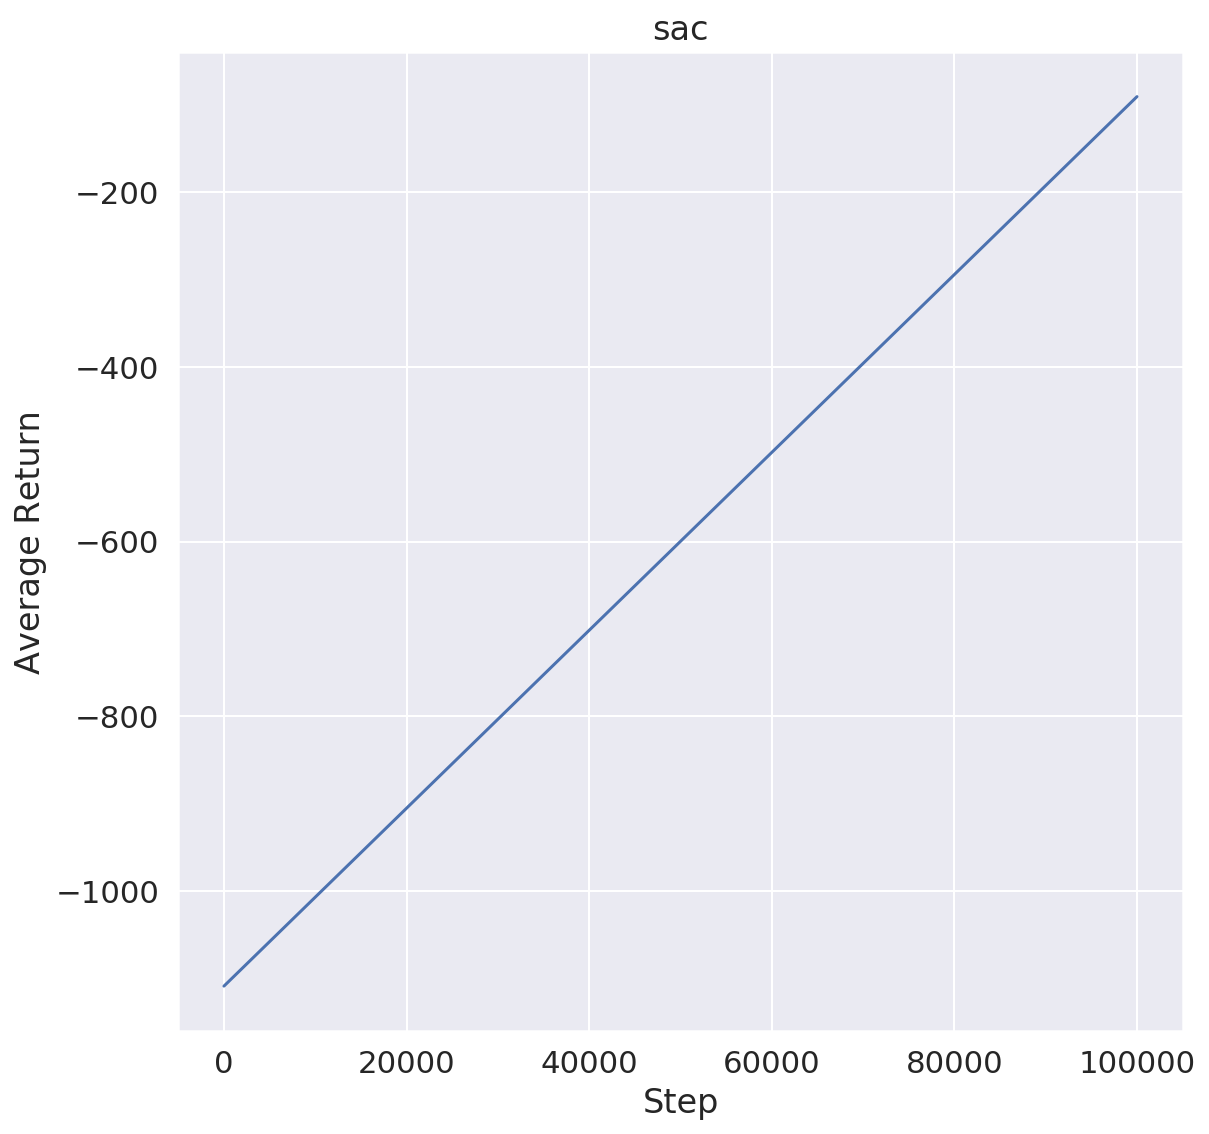

In [7]:
from tf_agents.agents.sac import sac_agent


def normal_projection_net(action_spec, init_means_output_factor=0.1):
    return normal_projection_network.NormalProjectionNetwork(
        action_spec,
        mean_transform=None,
        state_dependent_std=True,
        init_means_output_factor=init_means_output_factor,
        std_transform=sac_agent.std_clip_transform,
        scale_distribution=True)


critic_net = critic_network.CriticNetwork(
    (train_env.observation_spec(),  train_env.action_spec()),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=critic_joint_fc_layer_params)

actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=actor_fc_layer_params,
    continuous_projection_net=normal_projection_net)

global_step = tf.compat.v2.Variable(0)
tf_agent = sac_agent.SacAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=alpha_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    train_step_counter=global_step)

returns, video_filename = train_and_evaluate_agent_ddpg(tf_agent, name='sac')
embed_mp4(video_filename)